# "Modello di Axelrod"
> "Implementazione del modello e analisi delle sue proprietà "

In questa relazione mi occuperò di studiare numericamente e, in parte, analiticiamente un modello Agent-Based di Cultural Dynamics, ovvero un'estensione vettoriale della dinamica delle opinioni: il modello di Axelrod.


## Introduzione

Negli ultimi anni si è iniziato a studiare i fenomeni collettivi, emergenti da un insieme di persone, attraverso un formlismo matematico afferente per lo più alla fisica statistica, scienza delle reti e più in generale ai sistemi complessi. Nonostante nella storia della scienza, ed in particolare della fisica, ci sono esempi di studiosi che hanno applicato modelli quantitativi a problemi che riguardavano la sociologia, solo negli ultimi anni si è formata una corrente di studi incentrata appunto sul descrivere il comportamento collettivo umano attraverso modelli matematici: la sociofisica. 

Uno dei primi campi di ricerca in questo ambito è stato la dinamica delle opinioni, in cui si cerca di descrivere come una opinione appunto possa essere trasmessa tra vari individui appartenenti ad una rete sociale, cercando di studiarne gli effetti finali "macroscopici", quali la formazione di un consenso unanime (problema simile a quello della transizione ferromagnetica) o la formazione di cluster di opinioni e la loro dinamica.
Uno dei modelli più importanti di dinamica delle opinioni è il Voter Model.
#### descrivere voter model
Il modello in esame in questa relazione può essere visto, almeno nella sua versione originale, come un insieme di Voter Model accoppiati. Esiste quindi un numero $F$ di possibili diversi argomenti (features culturali) per i quali un individuo può avere $Q$ diverse opinioni. Esempi di features possono essere “linguaggio, arte, **norme tecniche** e regole sociali” [1], *i quali valori delle opinioni possono cambiare solo attraverso un'influeanza sociale, quindi in questo modello non verrano considerati gli effetti di istituzioni centrali e mass media, ma la dinamica avverrà solamente tra individui il che porterà la rete sociale ad autorganizzarsi.*

Le proprietà chiave di questo modello sono principalmente due:
1. Individui che condividono un maggior numero di features hanno maggiore probabilità di interazione (homophily)
2. Ogni interazione aumenta il numero di features che i due soggetti hanno in comune.


Il modello è definito su un reticolo quadrato di lato $L$, in cui il numero totale degli individui è dunque $N=L^2$.
Su ogni sito $i$ è definito un set di $F$ features culturali $q_{i,f}$, numeri interi che vanno da 0 a $Q$ per ogni $f$ che va da 0 a $F$. Nello stato iniziale tutti i valori $q_{i,f}$ sono estratti in maniera casuale da una distribuzione uniforme. 

Ad ogni passo temporale viene scelto un sito $i$ random ed un suo primo vicino $j$ sempre random. Viene dunque estratta in maniera casuale una feature $f$ e se risulta che $q_{i,f} \neq q_{j,f}$ si prosegue col passo temporale successivo senza apportare modifiche, altrimenti se le due features risultano uguali, si estrae a sorte una seconda features $f'$ tale che $q_{i,f'} \neq q_{j,f'}$ e la prima si impone uguale alla seconda: $q_{i,f'} = q_{j,f'}$.

L'algoritmo è dunque formato da un ciclo di step elementari del tipo:

1. Estrazione random di $i$ tra 0 ed $N$
2. Estrazione random di $j$ tra i primi vicini di $i$
3. Estrazione random di $f$ tra 0 ed $F$
4. Se $q_{i,f} \neq q_{j,f}$:
    1. Step successivo
5. Altrimenti se $q_{i,f} = q_{j,f}$:
    1. Estrazione random di $f'$ tale che $q_{i,f'} \neq q_{j,f'}$
    2. Si impone $q_{i,f'} = q_{j,f'}$
    3. Step successivo



Per costruzione del tipo di interazione, l'evoluzione dinamica tende ad ordinare il sistema e a diminuire il numero dei differenti valori di $q$ relativi a ciascuna features $f$. È intuitivo che per bassi valori di $Q$ il sistema già inizialmente si trovi in uno stato piuttosto omogeneo se confrontato con sistemi con $Q>>1$  per cui la distribuzione dei valori di $q$ è molto più larga, perciò ci si aspetta una maggiore facilità per i casi con bassi valori di $Q$ di raggiungere un consenso, fenomeno verificato come vedremo dalle simulazioni.

Possiamo notare che nel caso in cui ogni coppia possibile di primi vicini condivida o tutte le features o nessuna, la dinamica del sistema si arresta. Tali stati prendono il nome Absorbing States che per definizione sono gli stati finali dell'evoluzione dinamica del sistema. Possono esistere vari tipi di Absorbing States come vedremo, che possono essere più o meno ordinati. Per sistemi di dimensione finita può essere verificato che la dinamica raggiunge sempre uno stato Absorbing in un tempo finito. 



La prima parte di questa relazione andrà a presentare i dati relativi agli studi effettuati appunto sulle proprietà degli Absorbing States finali. L'osservabile studiata in questa parte è una sorta di densità di magnetizzazione, $⟨s_{max}⟩$, ovvero il numero di siti che presentano lo stesso valore $q$ di una certa feature $f$, normalizzato col numero totale di elementi e mediato su varie realizzazioni della dinamica effettuate con gli stessi parametri **ma stati iniziali diversi**. Il parametro d'ordine attraverso il quale verrà studiato l'andamento di $⟨s_{max}⟩$ è $Q$, ovvero il numero di possibile scelte per ogni feature.

I risultati riportati si riferiscono a **vari valori di F ed N**.



In [11]:
#%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib as mpl
#mpl.rcParams['errorbar.capsize'] = 3

def iniState(N,F,Q):
    return np.random.randint(Q,size=(N,F))

def chooseBlat(a):
    b1=np.random.randint(D*2)
    if b1==0: 
        if (a+1)%L==0:
            b=a+1-L
        else: b=a+1
    elif b1==1:
        if a%L==0:
            b=a-1+L
        else: b=a-1
    elif b1==2: b=a+L
    else: b=a-L
    return b%N

def AdD(D,L):
    # This function returns the sparse adjacency matrix of a d-dimensonal  
    # integer lattice with side L and the total number of elements N=L**d
    # Only for Periodic Boundary Conditions
    
    import scipy.sparse as ss
    N=L**D
    A=ss.dok_matrix((N,N),dtype=int)   # integer
    for i in range(N):
        for j in range(D):
            A[i,(i+L**j)%N] = 1
            A[i,(i-L**j)%N] = 1
    return A.copy()#.tocoo()

def chooseB(a,A):
    return A[a].nonzero()[1][np.random.randint(2*D)]

def calcMag(indi):
    mag=np.zeros((F,Q))
    for f in range(F):
        for q in range(Q):
            for i in range(N):
                if indi[i,f]==q:
                    mag[f,q]+=1
    return mag/N

def Bdx(a):
    if (a+1)%L==0:
        b=a+1-L
    else: b=a+1
    return np.int(b)
        
def Bdw(a):
    b=a+L
    return np.int(b%N)

youtube: https://youtu.be/6qtMMBHcGIk

> youtube: https://youtu.be/6qtMMBHcGIk

9999


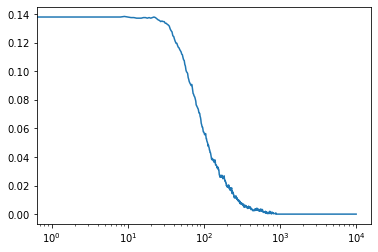

CPU times: user 1h 41min 12s, sys: 5.76 s, total: 1h 41min 18s
Wall time: 1h 41min 15s


In [101]:
%%time

Lv=np.array([50])
D=2
F=7
# Q=14

TN=10000
T=1000

nA=np.zeros(TN)

rep=1

Qrange=np.array([100])
qrange=np.arange(Qrange.size)
magv=np.zeros((Lv.size,Qrange.size,rep))
TCv=np.zeros((Lv.size,Qrange.size,rep))

ll=0
for L in Lv:
    N=L**D
    for rip in range(rep):
        q=0
        for Q in Qrange:

            TC=TN-1
            ind=np.zeros((TN+1,N,F),dtype=int)
            ind[0]=iniState(N,F,Q)
            indt=np.zeros((T+1,N,F),dtype=int)
            mag=np.zeros((TN,F,Q))
            
            

            for tnn in np.arange(TN):
                Act=np.zeros((D*N,2),dtype=int)-1
                for ai in range(N):
                    bi=Bdx(ai)
                    if (ind[tnn,ai]==ind[tnn,bi]).any() and (ind[tnn,ai]!=ind[tnn,bi]).any():
                        Act[D*ai]=np.array([ai,bi])

                    ci=Bdw(ai)
                    if(ind[tnn,ai]==ind[tnn,ci]).any() and (ind[tnn,ai]!=ind[tnn,ci]).any():
                        Act[D*ai+1]=np.array([ai,ci])
                        
                nA[tnn]=(Act[:,0]+1).nonzero()[0].size
                
                if tnn>10:
                    if (mag[tnn-3,:,0]==mag[tnn-4,:,0]).all():
                        if(mag[tnn-2,:,0]==mag[tnn-3,:,0]).all():
                            if(mag[tnn-1]==mag[tnn-2]).all():
                                if(mag[tnn]==mag[tnn-1]).all():
                                    TC=tnn
                                    break
                
                mag[tnn]=calcMag(ind[tnn])
                
                indt[0]=ind[tnn].copy()
                for tn in np.arange(T):
                    a=np.random.randint(N)
                    b=chooseBlat(a)

                    indt[tn+1]=indt[tn].copy()

                    if (indt[tn,a]!=indt[tn,b]).any() and (indt[tn,a]==indt[tn,b]).any():
                        c=np.random.randint(F)
                        if indt[tn,a,c]==indt[tn,b,c]:
                            dd=np.random.randint(F)
                            for Fi in range(F):
                                d=(dd+Fi)%F
                                if indt[tn,a,d]!=indt[tn,b,d]:
                                    indt[tn+1,a,d]=indt[tn,b,d].copy()
                                    break

                ind[tnn+1]=indt[tn+1].copy()
                
                print('{}\r'.format(tnn), end="")


            #mag[TC:]=mag[TC]
            magv[ll,q,rip]=np.amax(mag[TC])
            TCv[ll,q,rip]=TC
            q+=1
        
    ll+=1
    
print()
for i in range(Lv.size):
    plt.plot(range(TC),nA[:TC]/N)
    plt.xscale("log")
plt.show()



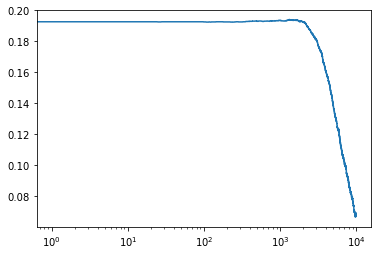

In [94]:
plt.plot(range(TC),nA[:TC]/N)
plt.xscale("log")

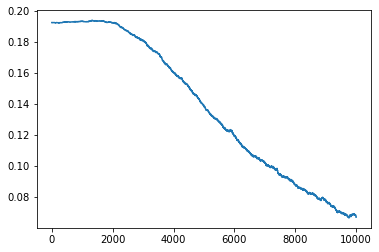

In [93]:
plt.plot(range(TC),nA[:TC]/N)
#plt.xscale("log")

In [ ]:
(Act+1).nonzero()

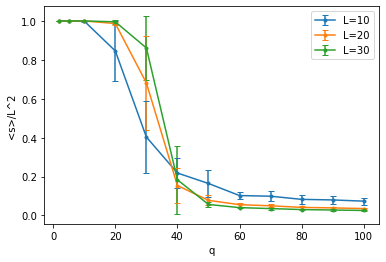

In [9]:
for i in range(Lv.size):
    plt.errorbar(Qrange,magv[i].mean(axis=1),yerr=magv[i].std(axis=1), label="L="+str(Lv[i]), marker='.')
    plt.xlabel('q')
    plt.ylabel('<s>/L^2')
    
plt.legend()
plt.show()

In [ ]:
'''                if (ind[tnn]==0).all():
                    TC=tnn
                    break
                    
                
                
                if tnn>10:
                    if (mag[tnn-3,:,0]==mag[tnn-4,:,0]).all():
                        if(mag[tnn-2,:,0]==mag[tnn-3,:,0]).all():
                            if(mag[tnn-1]==mag[tnn-2]).all():
                                if(mag[tnn]==mag[tnn-1]).all():
                                    TC=tnn-3
                                    break'''